# Example Notebook
A notebook with example usage of RamanLib capabilities, and example code to be adapted for your own Raman data analysis needs.

### Import packages

In [1]:
import ramanlib as rl
import ramanspy as rp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Code Examples

### Loading Raman Data From .csv File

In [2]:
def load_colon_spectra(csv_path):
    """
    Load colon tissue Raman spectra into a GroupedSpectralContainer from a CSV file.

    Filters to spectra labeled as 'Normal', 'Adenom', or 'Karzinom' and tissue type 'preparation'.
    Returns a GroupedSpectralContainer and a NumPy array of binary labels (0 = normal, 1 = abnormal).
    """

    # Read CSV
    df = pd.read_csv(csv_path)

    # Filter to valid, usable spectra
    df = df[
        df['Annotation'].isin(['Normal', 'Adenom', 'Karzinom']) &
        (df['Tissue'] == 'preparation')
    ]

    # Create binary labels
    label_map = {'Normal': 0, 'Adenom': 1, 'Karzinom': 1}
    labels = df['Annotation'].map(label_map).to_numpy()

    # Extract metadata
    replicates = df["Name"].str.split('_').str[0]
    metadata = [
        {
            "annotation": annotation,
            "name": name,
            "tissue": tissue,
            "replicate": replicate,
            "label": label  # binary: 0 or 1
        }
        for annotation, name, tissue, replicate, label in zip(
            df['Annotation'], df['Name'], df['Tissue'], replicates, labels
        )
    ]

    # Isolate spectral data
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove index column if present
    spectral_df = df.drop(columns=['Name', 'Annotation', 'Tissue'])

    # Extract spectra and axis
    spectra_array = spectral_df.to_numpy()
    spectral_axis = spectral_df.columns.astype(float).to_numpy()

    # Build Spectrum objects
    spectra = [
        rp.Spectrum(spectral_data, spectral_axis)
        for spectral_data in spectra_array
    ]

    # Return wrapped container
    container = rl.GroupedSpectralContainer(spectral_list=spectra, metadata=metadata)
    return container, labels

In [3]:
raw_gsc, labels = load_colon_spectra("/home/linux_thoma/git/aranexx_sers_analysis/ramanlib/DATA_dp_wc_bc.csv")

### Visualising Raw Data

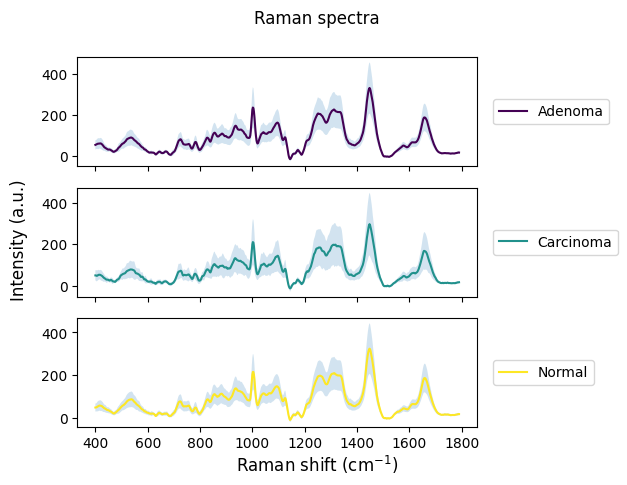

In [4]:
rl.plot.mean_per_group(raw_gsc,
                       by="annotation",
                       plot_type="stacked",
                       label=["Adenoma", "Carcinoma", "Normal"],
                       interval="sd")
plt.show()

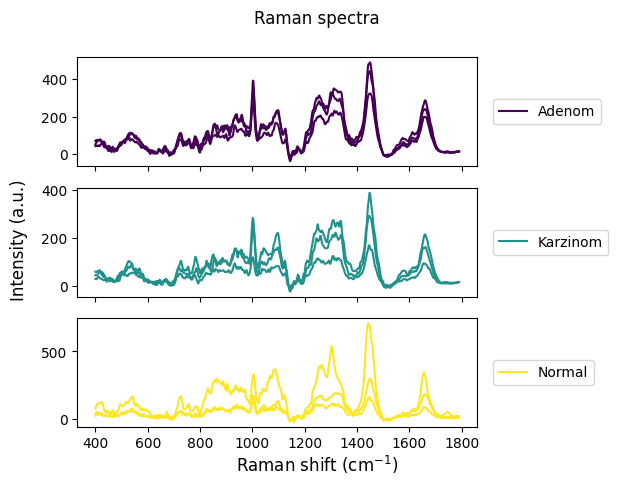

In [5]:
rl.plot.random_per_group(raw_gsc,
                         "annotation",
                         n_samples=3,
                         plot_type="stacked")
plt.show()

In [6]:
len(raw_gsc)

440

In [7]:
# See counts of each annotation
print("Annotation counts:")
print(raw_gsc.df['annotation'].value_counts())

Annotation counts:
annotation
Normal      226
Adenom      153
Karzinom     61
Name: count, dtype: int64


In [8]:
# Check combinations of tissue type, annotation and label
print("Annotation by tissue type:")
print(raw_gsc.df.groupby(['tissue', 'annotation', 'label']).size())

Annotation by tissue type:
tissue       annotation  label
preparation  Adenom      1        153
             Karzinom    1         61
             Normal      0        226
dtype: int64


### Indexing data using Grouped Spectral Containers

The Grouped Spectral Container class has been designed to be a relatively light-weight addition to the pandas dataframe. The main purpose is to provide abstracted methods for creating a container, so that the format of each container consistent whenever a container is created or modified (for example, always having a 'Spectrum' column). This allows for consistent handling of the data by external methods.

Additionally, a few core functions are encapsulated in the class for convenience, including GroupedSpectralContainer.mean which returns the mean spectra by metadata group, along with group statistics. This functionality is used repeatedly by external functions that required mean spectra, so it is implemented as a method of the class.

Users are expected to handle data mainly through the dataframe object of the GSC class, which is contained in the GroupedSpectralContainer.df attribute. This way, they can utilise any of pandas' wide breadth of data manipulation methods, while having the consistent format of a Grouped Spectral Container.

For convenience, the GSC class allows users to access data rows by key and boolean indexing, just as you would with a panda dataframe. The result is a GSC containing the resulting rows. This is the main intended method for indexing the GSC. Some examples are shown below.

In [ ]:
print(raw_gsc)
# Print summary of the Grouped Spectral Container to see its columns and structure

GroupedSpectralContainer(440 spectra)

                                            spectrum annotation          name  \
0  <ramanspy.core.Spectrum object at 0x7f093b210fa0>     Normal  M10_C2_I_001   
1  <ramanspy.core.Spectrum object at 0x7f093b210ee0>     Normal  M10_C2_I_002   
2  <ramanspy.core.Spectrum object at 0x7f08c9306550>     Normal  M10_C2_I_003   
3  <ramanspy.core.Spectrum object at 0x7f08c93065b0>     Normal  M10_R1_I_001   
4  <ramanspy.core.Spectrum object at 0x7f08c9306520>     Normal  M10_R1_I_002   

        tissue replicate  label  
0  preparation       M10      0  
1  preparation       M10      0  
2  preparation       M10      0  
3  preparation       M10      0  
4  preparation       M10      0  

In [49]:
raw_gsc[raw_gsc["name"] == "M10_C2_I_002"] # Get spectrum with specific name

GroupedSpectralContainer(1 spectra)

                                            spectrum annotation          name  \
0  <ramanspy.core.Spectrum object at 0x7f093b210ee0>     Normal  M10_C2_I_002   

        tissue replicate  label  
0  preparation       M10      0  

In [52]:
raw_gsc[raw_gsc["annotation"] == "Normal"] # Get all normal spectra

GroupedSpectralContainer(226 spectra)

                                            spectrum annotation          name  \
0  <ramanspy.core.Spectrum object at 0x7f093b210fa0>     Normal  M10_C2_I_001   
1  <ramanspy.core.Spectrum object at 0x7f093b210ee0>     Normal  M10_C2_I_002   
2  <ramanspy.core.Spectrum object at 0x7f08c9306550>     Normal  M10_C2_I_003   
3  <ramanspy.core.Spectrum object at 0x7f08c93065b0>     Normal  M10_R1_I_001   
4  <ramanspy.core.Spectrum object at 0x7f08c9306520>     Normal  M10_R1_I_002   

        tissue replicate  label  
0  preparation       M10      0  
1  preparation       M10      0  
2  preparation       M10      0  
3  preparation       M10      0  
4  preparation       M10      0  

### Getting the Mean Spectra of groups from a GroupedSpectralContainer

This is one of the only processing functions provided as a method of GSC, because of how common it is to calculate the mean spectra of a GSC.

In [57]:
raw_gsc.mean(by="annotation", include_stats=False)

GroupedSpectralContainer(3 spectra)

                                            spectrum annotation
0  <ramanspy.core.Spectrum object at 0x7f08c8738820>     Adenom
1  <ramanspy.core.Spectrum object at 0x7f08c832ca90>   Karzinom
2  <ramanspy.core.Spectrum object at 0x7f08c867e1f0>     Normal

If include_stats is set to True, columns are included for the number of spectra, n, and variance and standard deviation vectors representing the respective statistics at each wavenumber.

In [60]:
raw_gsc.mean(by="annotation", include_stats=True)

GroupedSpectralContainer(3 spectra)

                                            spectrum annotation    n  \
0  <ramanspy.core.Spectrum object at 0x7f08c82365e0>     Adenom  153   
1  <ramanspy.core.Spectrum object at 0x7f08c920f3a0>   Karzinom   61   
2  <ramanspy.core.Spectrum object at 0x7f08c867eb50>     Normal  226   

                                          var_vector  \
0  [520.4194673877299, 503.88377010656234, 512.23...   
1  [571.2872052156648, 657.1600115317982, 715.176...   
2  [367.4185047731241, 352.60715821628526, 372.02...   

                                          std_vector  
0  [22.812704078818232, 22.447355525909114, 22.63...  
1  [23.90161511730253, 25.63513236813491, 26.7427...  
2  [19.168163834158037, 18.777836888637765, 19.28...  

### Calibrate Raw Spectra

#### Example: Detecting wavenumber shift from internal Si calibration standard

To demonstrate the calibration functions, I generate hypothetical internal silicon spectral data, which contains a single high-intensity peak. A study conducted by Itoh et al. estimates that the main silicon band is situated at 520.45 ± 0.28 cm-1 for Si 100.

In [9]:
# Generate hypothetical internal silicon standard spectra
from datetime import date

# Parameters
n = 100
ideal_center = 520.45
allowed_halfwidth = 0.28
center_sd = 0.2      # ~few % outside the window
amp_range = (800, 1200)
sigma_range = (0.3, 0.6)
noise_frac = 0.02
seed = 7

rng = np.random.default_rng(seed)

# Wavenumber axis around the Si line
x = np.linspace(480, 560, 1601)

# Random peak parameters
centers = rng.normal(ideal_center, center_sd, size=n)
amps    = rng.uniform(*amp_range, size=n)
sigmas  = rng.uniform(*sigma_range, size=n)

spectra = []
for c, a, s in zip(centers, amps, sigmas):
    y = a * np.exp(-(x - c)**2 / (2 * s**2))
    y += rng.normal(0.0, noise_frac * a, size=x.shape)  # noise
    spectra.append(rp.Spectrum(y, x))

# Minimal fake metadata: rotating dates and 3x3 spots
dates = [date(2025, 8, 1), date(2025, 8, 2)]
spots = [f"({r},{c})" for r in range(1, 4) for c in range(1, 4)]
metadata = [{"date": dates[i % len(dates)], "spot": spots[i % len(spots)]} for i in range(n)]

# Build GroupedSpectralContainer
calib_gsc = rl.GroupedSpectralContainer(spectra, metadata)

Plot randomly selected spectra to visualy verify.

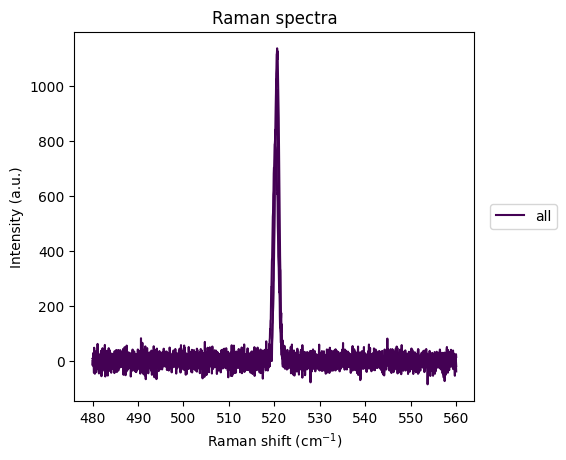

In [10]:
calib_gsc.plot_random(n_samples=3, seed=seed)
plt.show()

Check the calibration of a single spectrum

-0.20040853529974356


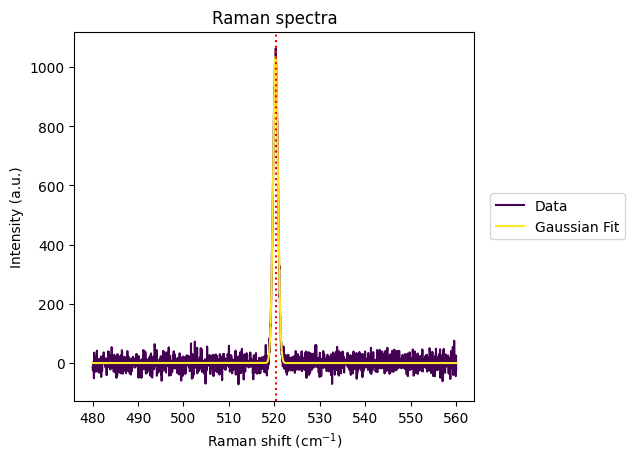

In [11]:
shift_value = rl.calib.get_wn_shift(calib_gsc["spectrum"].iloc[5], 520.45, plot=True)
print(shift_value)
plt.show()

Check the calibration of the entire GSC and return a GSC of uncalibrated spectra

In [12]:
fail_gsc, new_gsc = rl.calib.get_gsc_wn_shifts(
    calib_gsc,
    [520.17, 520.73],
    520.45
)

In [13]:
print(fail_gsc)
print(fail_gsc["shift"].abs().min())
# All shifts in the fail gsc are above 0.28, as expected, since we used the range 520.45 +- 0.28

GroupedSpectralContainer(11 spectra)

                                            spectrum        date   spot  \
0  <ramanspy.core.Spectrum object at 0x7f08c8638d90>  2025-08-01  (1,1)   
1  <ramanspy.core.Spectrum object at 0x7f08c8638e80>  2025-08-01  (1,3)   
2  <ramanspy.core.Spectrum object at 0x7f08c8638f40>  2025-08-01  (3,3)   
3  <ramanspy.core.Spectrum object at 0x7f08c8638cd0>  2025-08-01  (2,1)   
4  <ramanspy.core.Spectrum object at 0x7f08c86634f0>  2025-08-02  (1,1)   

       x0_fit     shift  
0  520.069173 -0.380827  
1  520.081641 -0.368359  
2  519.940991 -0.509009  
3  520.144087 -0.305913  
4  520.141240 -0.308760  
0.2853408681394285


In [14]:
print(new_gsc)

GroupedSpectralContainer(100 spectra)

                                            spectrum        date   spot  \
0  <ramanspy.core.Spectrum object at 0x7f08c8644c40>  2025-08-01  (1,1)   
1  <ramanspy.core.Spectrum object at 0x7f093b2c1ac0>  2025-08-02  (1,2)   
2  <ramanspy.core.Spectrum object at 0x7f08c8644be0>  2025-08-01  (1,3)   
3  <ramanspy.core.Spectrum object at 0x7f08c8644d00>  2025-08-02  (2,1)   
4  <ramanspy.core.Spectrum object at 0x7f08c8644d60>  2025-08-01  (2,2)   

       x0_fit     shift  
0  520.447505 -0.002495  
1  520.509446  0.059446  
2  520.396104 -0.053896  
3  520.271215 -0.178785  
4  520.355366 -0.094634  


Using the shift values and dates given in these grouped spectra containers, we are able to apply a wavenumber shift to other data collected on or near the same day.

### Choose Best Baseline Subtraction Algorithm

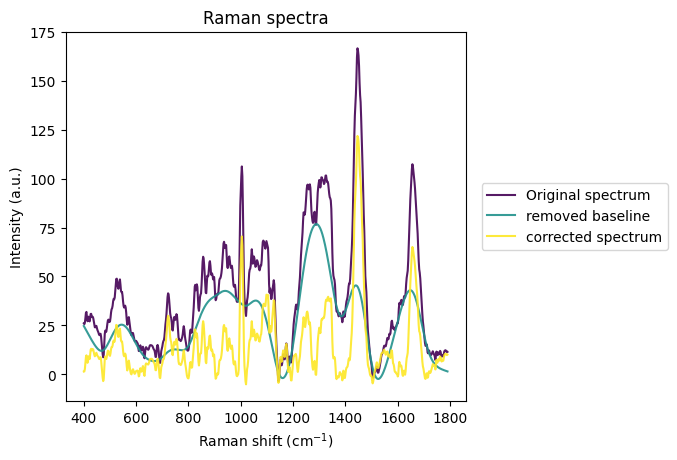

In [15]:
rl.plot.baseline(raw_gsc["spectrum"].iloc[0], rp.preprocessing.baseline.ASLS(lam=1000))
plt.show()

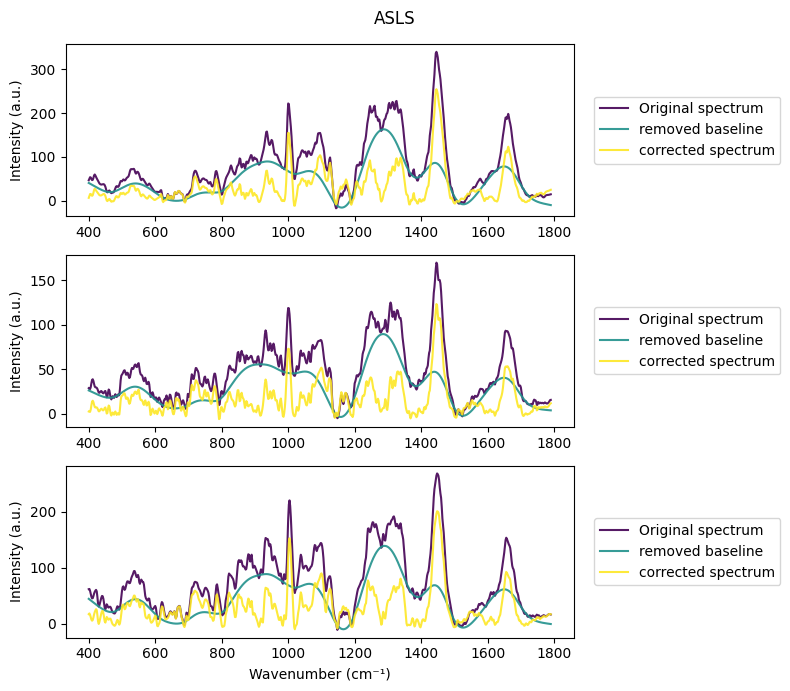

In [16]:
rl.plot.n_baselines(raw_gsc, rp.preprocessing.baseline.ASLS(lam=1000), "ASLS")
plt.show()

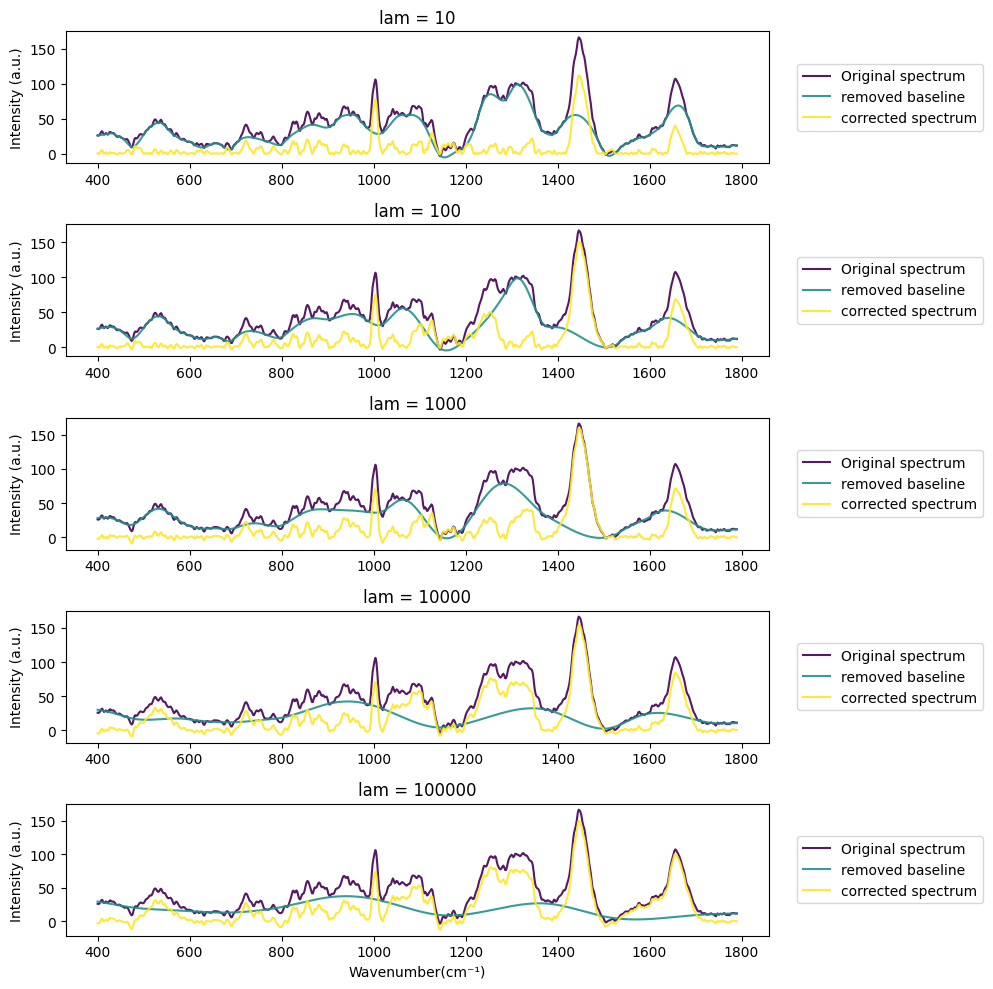

In [17]:
processes = [
    rp.preprocessing.baseline.IARPLS(lam=10),
    rp.preprocessing.baseline.IARPLS(lam=100),
    rp.preprocessing.baseline.IARPLS(lam=1000),
    rp.preprocessing.baseline.IARPLS(lam=10000),
    rp.preprocessing.baseline.IARPLS(lam=100000)
]

names = [
    "lam = 10",
    "lam = 100",
    "lam = 1000",
    "lam = 10000",
    "lam = 100000"
]
rl.plot.compare_baselines(raw_gsc["spectrum"].iloc[0], processes, names, figsize=(10,10))
plt.show()

### Pipeline

In [18]:
# Define the pipeline.
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(lam = 300),
    rp.preprocessing.normalise.MaxIntensity(),
])

In [19]:
prepro_gsc = raw_gsc.apply_pipeline(pipe)

### Visualising Preprocessed Spectra

#### Individual Spectra

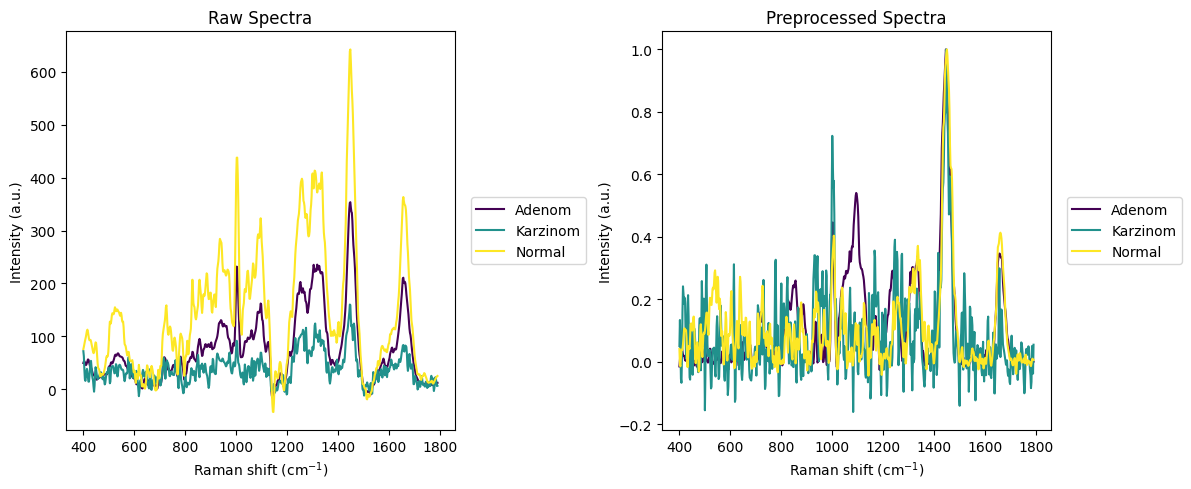

In [20]:
# Plot random spectra before and after preprocessing
# Create 1 row, 2 column subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot randomly selected raw spectra
rl.plot.random_per_group(raw_gsc, by="annotation", plot_type="single", ax=ax1, title="Raw Spectra", n_samples=1)
# Plot randomly selected preprocessed spectra
rl.plot.random_per_group(prepro_gsc, by="annotation", plot_type="single", ax=ax2, title="Preprocessed Spectra", n_samples=1)
plt.tight_layout()
plt.show()

#### Mean Spectra

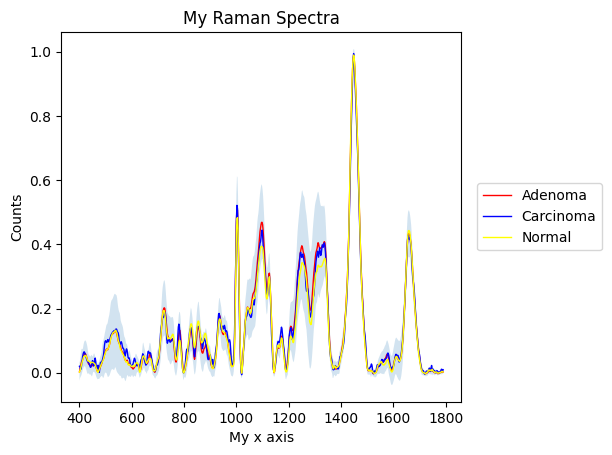

In [21]:
# Demonstrate the full customisability of the plot functions
prepro_gsc.plot_mean(
    by=["annotation", "label"],
    interval="sd",
    plot_type="single",
    linewidth=1,
    label=["Adenoma", "Carcinoma", "Normal"],
    color=["red", "blue", "yellow"],
    title="My Raman Spectra",
    xlabel="My x axis",
    ylabel="Counts"
)
plt.show()                     

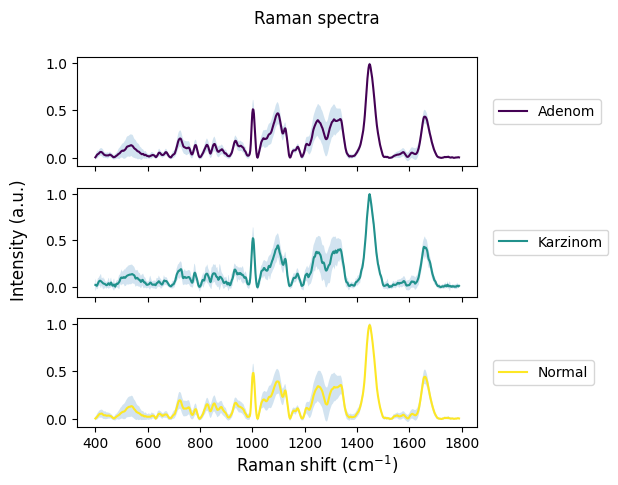

In [22]:
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="stacked", interval="sd")
plt.show()

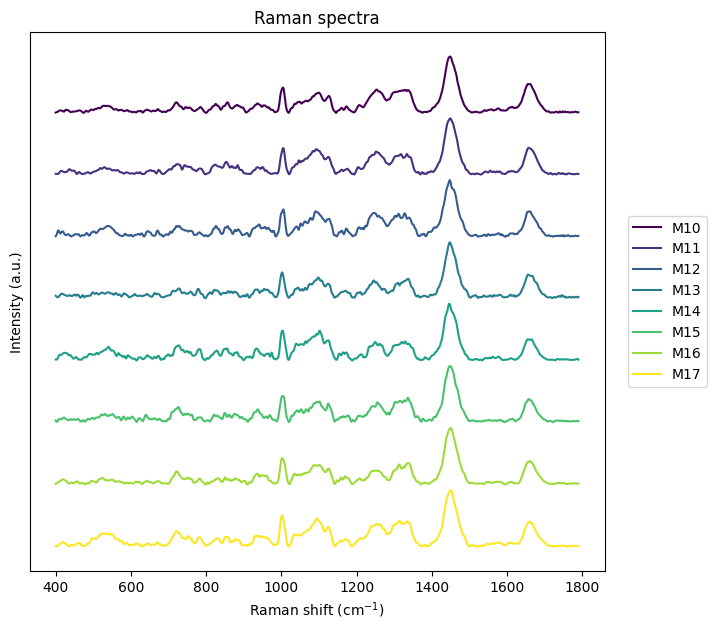

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
rl.plot.mean_per_group(rl.GroupedSpectralContainer.from_dataframe(prepro_gsc.df.iloc[0:150]), "replicate", plot_type="single stacked")
plt.show()

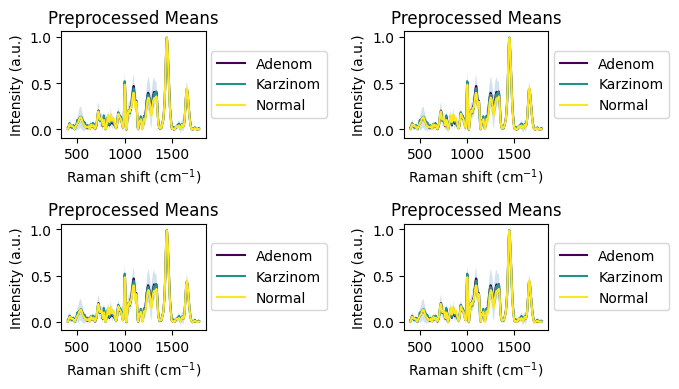

In [ ]:
# Just for demonstration purposes, plot the same mean spectra 4 times in a 2x2 grid
# This shows how to create subplots and pass axes to the plot functions

# Create 1 row, 2 column subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7, 4))  # Adjust figsize as needed

# Plot mean spectra before and after preprocessing
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=axes[0,0], title="Preprocessed Means", interval="sd")
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=axes[0,1], title="Preprocessed Means", interval="sd")
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=axes[1,0], title="Preprocessed Means", interval="sd")
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=axes[1,1], title="Preprocessed Means", interval="sd")
plt.tight_layout()
plt.show()

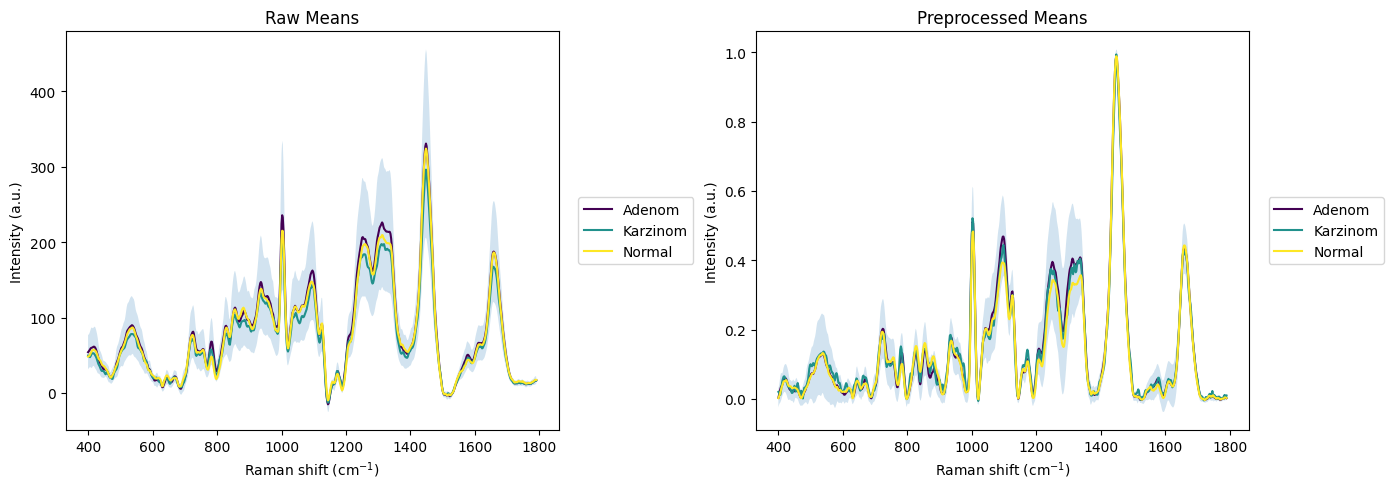

In [25]:
# Plot mean spectra before and after preprocessing
# Create 1 row, 2 column subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Adjust figsize as needed

# Plot mean spectra before and after preprocessing
rl.plot.mean_per_group(raw_gsc, "annotation", plot_type="single", ax=ax1, title="Raw Means", interval="sd")
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=ax2, title="Preprocessed Means", interval="sd")
plt.tight_layout()
plt.show()

### Quality Control

In [26]:
results = rl.calc.outliers_per_group(prepro_gsc, rp.metrics.MSE, by="annotation", n_spectra=1)
results

{'Adenom': ([148], <ramanspy.core.Spectrum at 0x7f08c8701250>),
 'Karzinom': ([69], <ramanspy.core.Spectrum at 0x7f08c0fe96a0>),
 'Normal': ([393], <ramanspy.core.Spectrum at 0x7f08c8083370>)}

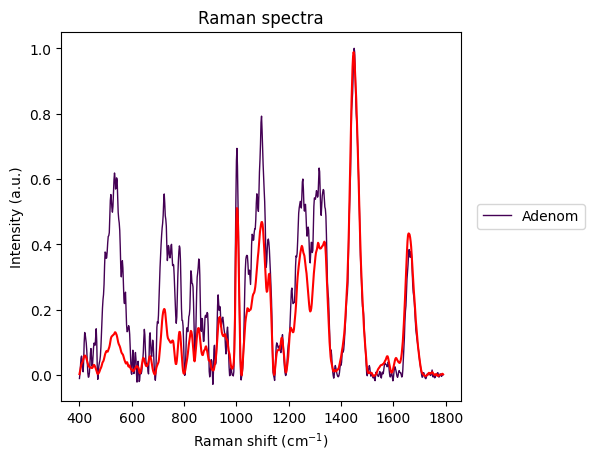

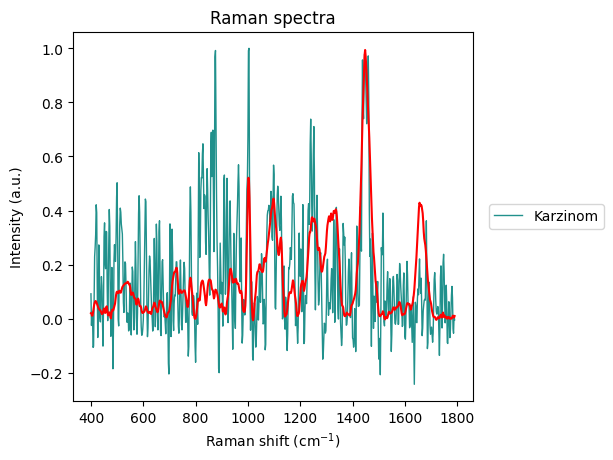

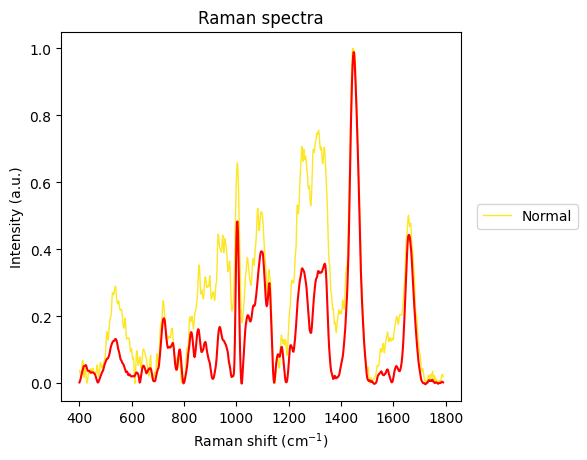

In [27]:
axes = rl.plot.outliers_per_group(prepro_gsc, results, linewidth=1)
plt.show()

The Carcinoma sample at index 69 looks like an error in measurement has made it too noisy, so we will remove it from the dataset.

In [28]:
cleaned_gsc = rl.GroupedSpectralContainer.from_dataframe(prepro_gsc.df.drop(prepro_gsc.df.index[69]))

Now when we redo the outliers calculation, the Carcinoma index return 59, showing that the spectrum at index 69 was removed successfully. 59 is now the index of the next most-outlying spectrum.

In [29]:
results = rl.calc.outliers_per_group(cleaned_gsc, rp.metrics.MSE, by="annotation", n_spectra=1)
results

{'Adenom': ([147], <ramanspy.core.Spectrum at 0x7f08c0ef6190>),
 'Karzinom': ([59], <ramanspy.core.Spectrum at 0x7f08c0ef6220>),
 'Normal': ([392], <ramanspy.core.Spectrum at 0x7f08c0ef65b0>)}

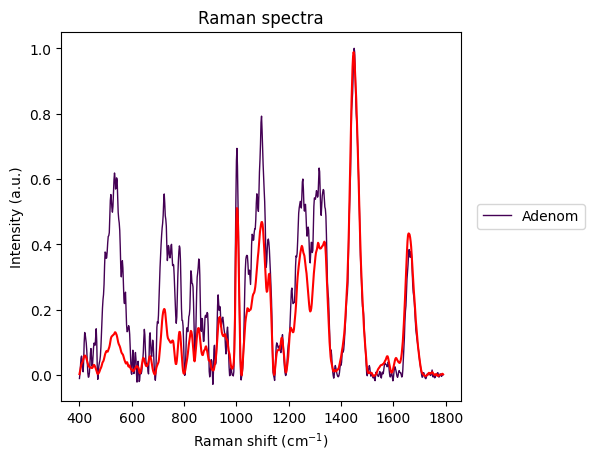

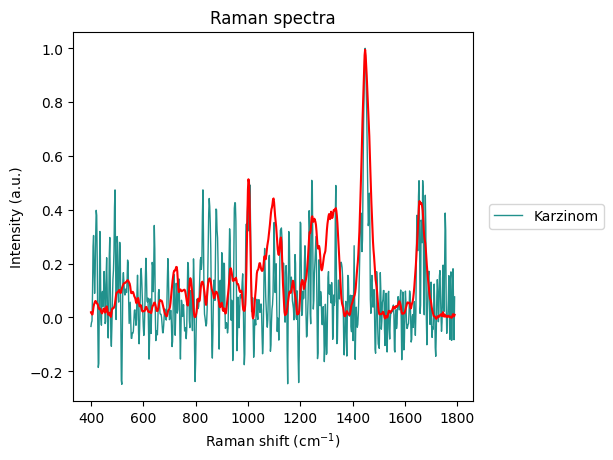

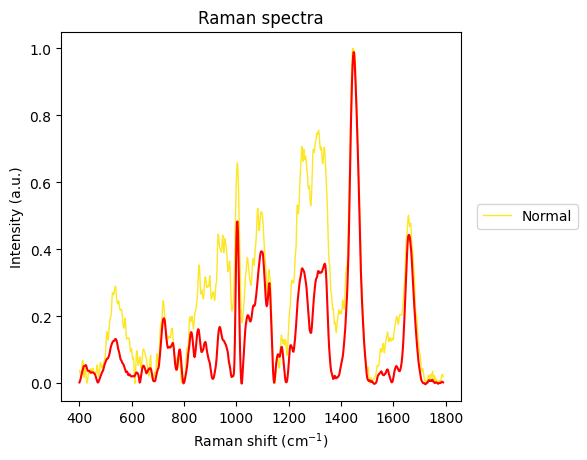

In [30]:
axes = rl.plot.outliers_per_group(cleaned_gsc, results, linewidth=1)
plt.show()

### Between-Group Analysis

#### Difference in Mean Spectra

In [31]:
group_stats = prepro_gsc.mean(by="annotation", include_stats=True)
group1_stats = group_stats[group_stats["annotation"]=="Normal"]
group2_stats = group_stats[group_stats["annotation"]=="Adenom"]
group3_stats = group_stats[group_stats["annotation"]=="Karzinom"]

In [32]:
diff_spectrum_1, ci_band_1 = rl.calc.mean_difference(group1_stats, group2_stats)
diff_spectrum_2, ci_band_2 = rl.calc.mean_difference(group2_stats, group3_stats)
diff_spectrum_3, ci_band_3 = rl.calc.mean_difference(group3_stats, group1_stats)

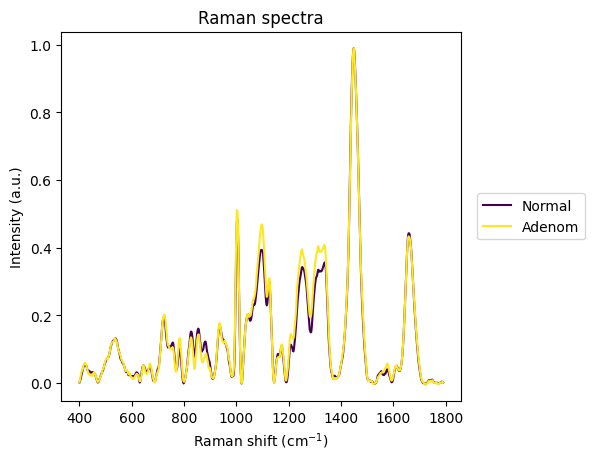

In [33]:
rp.plot.spectra([group1_stats["spectrum"].iloc[0], group2_stats["spectrum"].iloc[0]], plot_type="single", label=["Normal", "Adenom"])
plt.show()

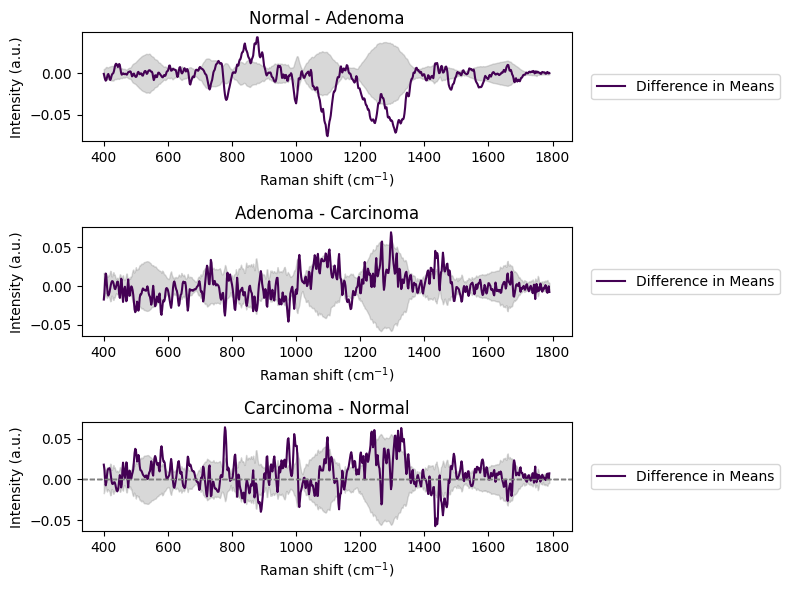

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
rl.plot.mean_difference(diff_spectrum_1, ci_band_1, title="Normal - Adenoma", ax=axs[0])
rl.plot.mean_difference(diff_spectrum_2, ci_band_2, title="Adenoma - Carcinoma", ax=axs[1])
rl.plot.mean_difference(diff_spectrum_3, ci_band_3, title="Carcinoma - Normal", ax=axs[2])
plt.tight_layout()
plt.show()


#### Correlation Coefficient by Annotation

In [35]:
corr = rl.calc.mean_correlation_per_group(prepro_gsc, "annotation")

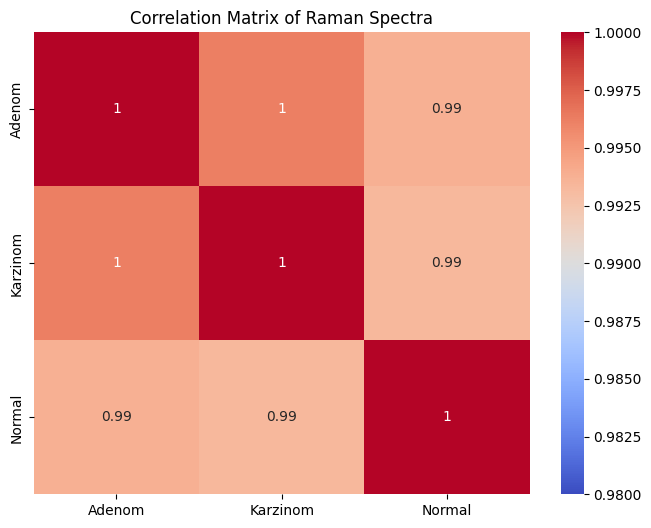

In [36]:
rl.plot.mean_correlation_per_group(corr, vmin=0.98)
plt.show()

#### Correlation Coefficient by Replicate

In [37]:
corr = rl.calc.mean_correlation_per_group(prepro_gsc, "replicate")

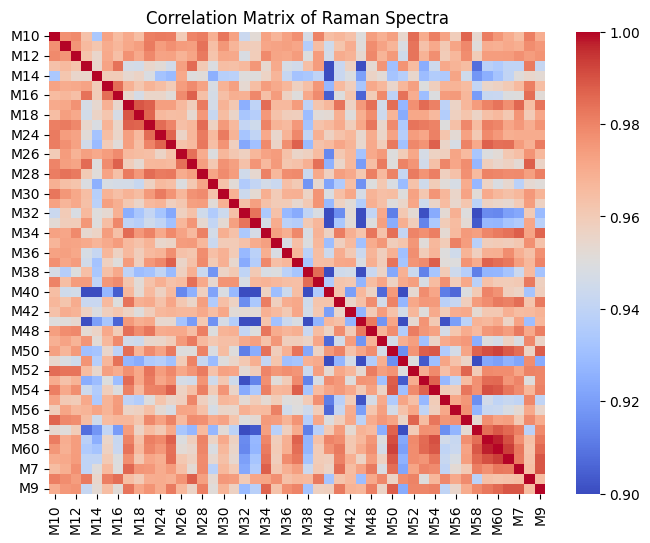

In [38]:
rl.plot.mean_correlation_per_group(corr, annot=False, vmin=0.90, vmax=1.0)
plt.show()

#### Next step: Loading and score plots (Guo et al SOP step 23)

### Classical Least Squares for Spectral Subtraction

The CLS algorithm works on single spectra, so here I import data directly as ramanspy Spectrum objects. These can be mean spectra or single spectra as needed.

In [39]:
import os

# Base directory: folder containing this script
BASE_DIR = os.getcwd()

# Example data folder inside ramanlib
DATA_DIR = os.path.join(BASE_DIR, "CLS_example_data")

# Build relative paths
grating = rp.load.renishaw(os.path.join(DATA_DIR, "grating 10s 50_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))
water = rp.load.renishaw(os.path.join(DATA_DIR, "water 10s 10_ 3acc 532nm 1200lmm extended range 200-3600 spot 3.wdf"))
ethanol = rp.load.renishaw(os.path.join(DATA_DIR, "ethanol 10s 1_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))
water_and_ethanol = rp.load.renishaw(os.path.join(DATA_DIR, "water and ethanol 10s 10_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))

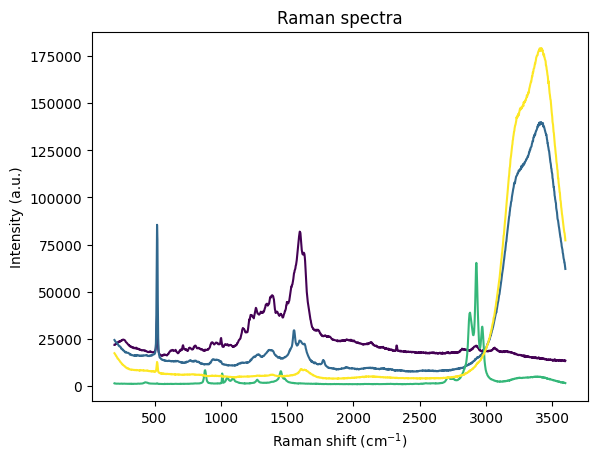

In [40]:
rp.plot.spectra([grating, water, ethanol, water_and_ethanol], plot_type="single")
plt.show()

In [41]:
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(lam = 3000),
    rp.preprocessing.normalise.MaxIntensity(),
])

grating_prepro = pipe.apply(grating)
water_prepro = pipe.apply(water)
ethanol_prepro = pipe.apply(ethanol)
water_and_ethanol_prepro = pipe.apply(water_and_ethanol)

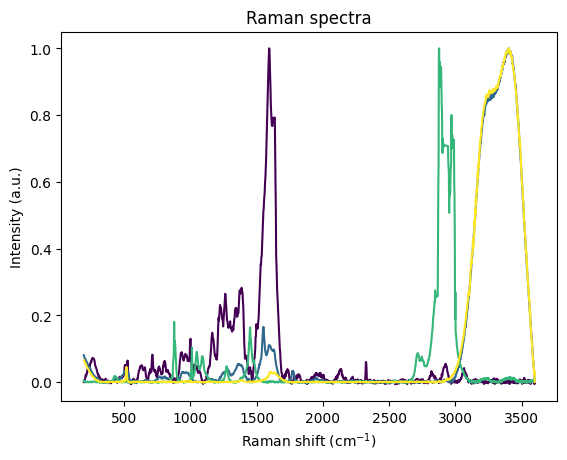

In [42]:
rp.plot.spectra([grating_prepro, water_prepro, ethanol_prepro, water_and_ethanol_prepro], plot_type="single")
plt.show()

components:
grating, -0.11092895269393921
water, 1.0101244449615479
ethanol, 0.012555450201034546


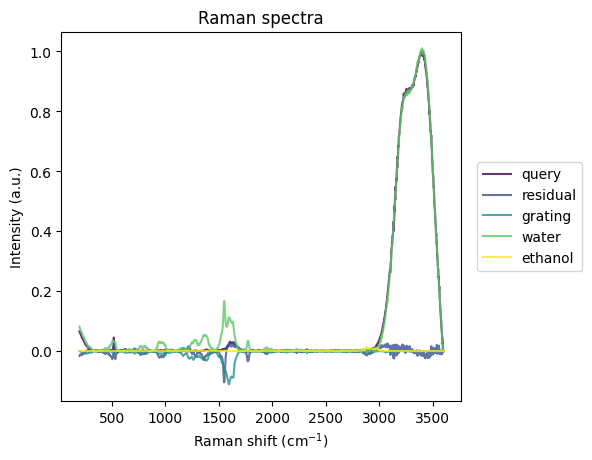

In [43]:
cs, res_spec, fitted_components_spec = rl.analysis.CLS(water_and_ethanol_prepro, [grating_prepro, water_prepro, ethanol_prepro], ["grating", "water", "ethanol"])
plt.show()